In [1]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data as web # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

## New Imports

In [2]:
#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns

## Dates & Other Constants

In [3]:
# Define path to files
# For MacOS
PATH = "/Users/oppoudel/dev/Python4Finance/Stocks_DW/"
# For Windows
# PATH = "D:/Python for Finance/Stocks/"

# Start date defaults
S_YEAR = 2017
S_MONTH = 1
S_DAY = 3
S_DATE_STR = "2017-01-03"
S_DATE_DATETIME = dt.datetime(S_YEAR, S_MONTH, S_DAY)

# End date defaults
E_YEAR = 2021
E_MONTH = 8
E_DAY = 19
E_DATE_STR = "2021-08-19"
E_DATE_DATETIME = dt.datetime(E_YEAR, E_MONTH, E_DAY)

## Function that Returns a Dataframe from a CSV

In [4]:
def get_df_from_csv(ticker):
    try:
        df = pd.read_csv(PATH + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Regression Analysis

Used to examine the relationship between 2 or more variables. We use it to see what factors matter & which do not. The dependent variable is what you want to better understand, while the independent variable effects the dependent.

When analyzing stocks the dependent variable is the price, while the independent may be the season, economic events, earnings, etc. 

<AxesSubplot:xlabel='eval', ylabel='beauty'>

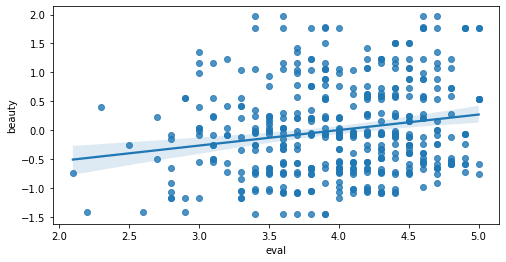

In [5]:
# This is a dataset that evaluates beauty & teacher evaluations
beauty = sm.datasets.get_rdataset("TeachingRatings", "AER")

# We are plotting a scatter plot with a regression line that
# estimates the mean of the results.
plt.figure(figsize=(8,4))
sns.regplot(x="eval", y="beauty", data=beauty.data)

# This data is rather inconclusive

## Tips Regression Line

/Users/oppoudel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<AxesSubplot:xlabel='total_bill', ylabel='tip'>

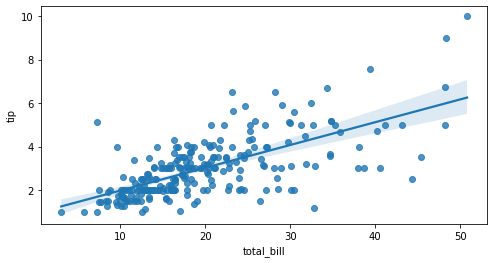

In [6]:
# This time will we analyze whether the total bill effects
# the tip people leave at restaurants
# Load tip dataset
tips = sns.load_dataset("tips")
# Get column data in dataset
tips.columns

y = tips['total_bill']
x1 = tips['tip']

# Define the intercept to the y line
x = sm.add_constant(x1)

# OLS Ordinary Least Squares : Estimates the data so a line can 
# be drawn through data points
results = sm.OLS(y,x).fit()
results.summary()

plt.figure(figsize=(8,4))
sns.regplot(x="total_bill", y="tip", data=tips)

# Here it is clear that are guess that bill amounts effect tips
# seems to be true

## Forecasting

You are going to choose different models depending upon the data you have. We will train our model on the first group of data (Training Data : 1st 80%). Then we test the model using the last part of our data (Test Date : Last 20%). All along we are modeling using real known true results. We should forecast into the future the same length of time we test for.

These forecasts are based off of the trends provided by the data you supply. Will it definitely happen? No, but it is more likely to continue on its current trend depending on how dramatic the slope is for the prejection. If nothing dramatic occurs! But, as we know, dramatic things happen such as wars and pandemics.

## ARIMA Model (Auto Regression)

AutoRegressive Integrated Moving Average (ARIMA) is the basis for many other models. It focuses on trying to fit the data as well as possible by examining differences between values instead of the values themselves.

ARIMA works very well when data values have a clear trend and seasonality. We can only make predictions based on the data we have. Any outside effects not in the data can't be used to make predictions. For example we could make predictions on stock prices, but since we don't know when a recession may occur that event can't be modeled.

There is a seasonal (SARIMA) and a non-seasonal ARIMA. There is also SARIMAX which focuses on exogenous, or external factors. It differs from ARIMA in that it has a set of parameters (P, D, and Q) that focus on seasonality.

AR (Autoregressions) refers to a model that regresses based on prior values.

## Regression Time Series Example with AutoReg

/Users/oppoudel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


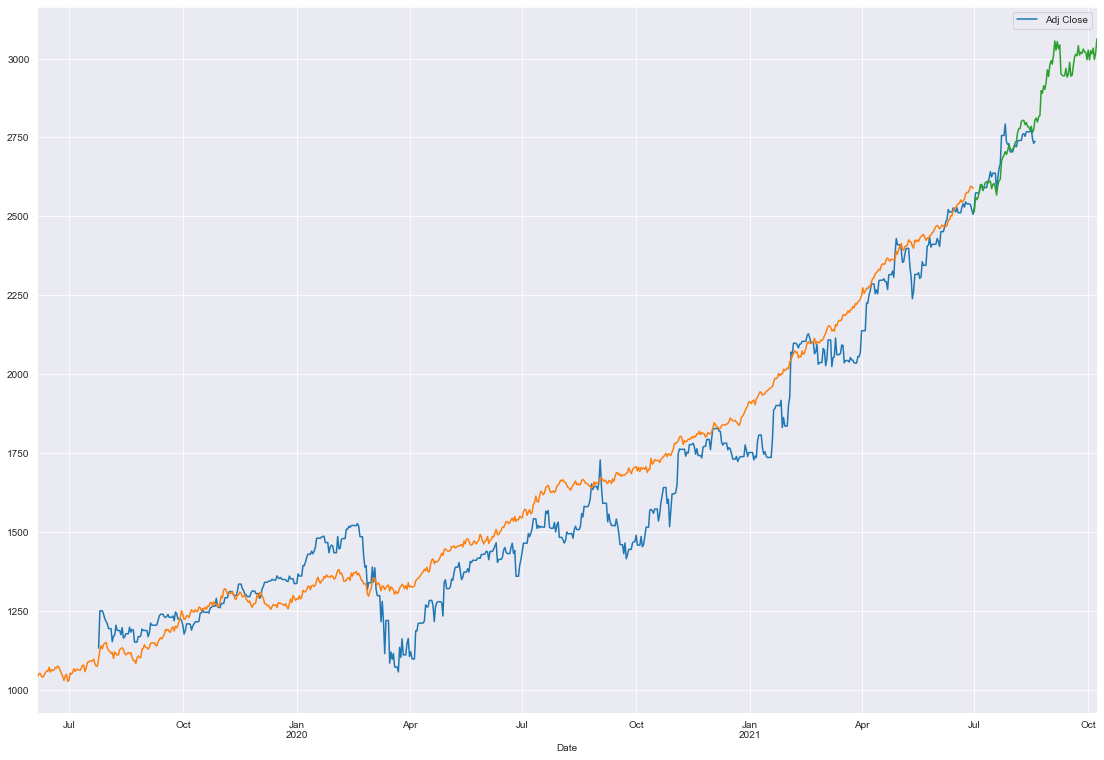

In [7]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

a_df = get_df_from_csv("GOOG") 

a_df = a_df.asfreq('d') # Change frequency to day
a_df.index # Check frequency
a_df = a_df.fillna(method='ffill') # Fill missing values

# Delete unnamed column
a_df.drop(a_df.columns[a_df.columns.str.contains('unnamed',case = False)],
          axis = 1, inplace = True)

# Delete daily return column
a_df = a_df.drop(['daily_return'], axis=1)

a_df

# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()
# ax = a_df.plot(ax=ax)

# Figure out optimum lags which will be 1 or 2 for this data set
lags = ar_select_order(a_df, maxlag=30)

# Create our model using whole data set
model = AutoReg(a_df['Adj Close'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
len(a_df) # 1166 observations
train_df = a_df.iloc[50:933] # 80% minus 1st 50
test_df = a_df.iloc[933:] # Last 20%

# Define training model for 500 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(a_df['Adj Close'], 500).fit(cov_type="HC0")

# Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # Orange
ax = prediction.plot(ax=ax) # Green

# Predict 100 days into the future
forecast = train_model.predict(start=end, end=end+100, dynamic=True)
ax = forecast.plot(ax=ax) # Green